<a href="https://colab.research.google.com/github/Avas77/email-spam-detection/blob/feature%2Fsmote-resampling/Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Libraries**



In [25]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("white")
import matplotlib.pyplot as plt
import string
from pickle import dump
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
import warnings
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.text import TextCollection
from sklearn.ensemble import RandomForestClassifier
import gensim
from gensim.models import LdaModel
from imblearn.over_sampling import SMOTE
warnings.simplefilter(action='ignore', category=FutureWarning)
nltk.download('stopwords')
nltk.download("wordnet")
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## **1. Data Loading**



In [2]:
emails_df = pd.read_json("hf://datasets/yxzwayne/email-spam-10k/email-spam-10k.json")
emails_df = emails_df.rename(columns={"is_spam": "spam"})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
emails_df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [4]:
emails_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10899 entries, 0 to 10898
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10899 non-null  object
 1   spam    10899 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 170.4+ KB


In [5]:
emails_df.describe()

,spam
count,10899.000000
mean,0.263052
std,0.440310
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## **2. Data Visualization**

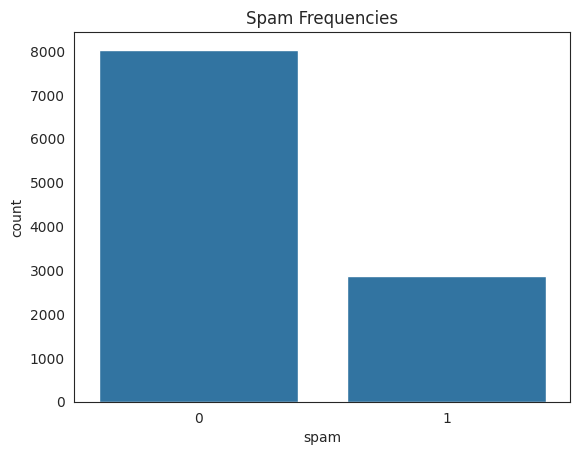

In [6]:
# visualize spam frequencies
plt.figure(dpi=100)
sns.countplot(x="spam", data=emails_df)
plt.title("Spam Frequencies")
plt.show()


## **3. Data Cleaning**

In [7]:
# Check for missing data for each column
emails_df.isnull().sum()

,0
text,0
spam,0


In [8]:
# Check for duplicates and remove them
emails_df.drop_duplicates(inplace=True)

In [9]:
def preprocess_text(text):
    # Remove "Subject:" from each text row
    text = re.sub(r"^subject:", "", text, flags=re.IGNORECASE).strip()
    wordnet_lemmatizer = WordNetLemmatizer()
    lowercase_sentence = text.lower()
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(lowercase_sentence)
    processed = []
    for token in tokens:
        if token not in stop_words and token not in string.punctuation and token.isalpha():
            lemmatized = wordnet_lemmatizer.lemmatize(token)
            processed.append(lemmatized)
    return processed

In [10]:
emails_df["preprocessed"] = emails_df["text"].apply(preprocess_text)
emails_df.head()

,text,spam,preprocessed
0,Subject: naturally irresistible your corporate...,1,"[naturally, irresistible, corporate, identity,..."
1,Subject: the stock trading gunslinger fanny i...,1,"[stock, trading, gunslinger, fanny, merrill, m..."
2,Subject: unbelievable new homes made easy im ...,1,"[unbelievable, new, home, made, easy, im, want..."
3,Subject: 4 color printing special request add...,1,"[color, printing, special, request, additional..."
4,"Subject: do not have money , get software cds ...",1,"[money, get, software, cd, software, compatibi..."


## **4. Feature Extration**

In [11]:
# Convert the list of words in 'preprocessed' column to a string format
emails_df['preprocessed_str'] = emails_df['preprocessed'].apply(lambda x: ' '.join(x))

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Apply TF-IDF on the 'preprocessed_str' column
tfidf_matrix = tfidf_vectorizer.fit_transform(emails_df['preprocessed_str'])
tfidf_matrix

<10688x59999 sparse matrix of type '<class 'numpy.float64'>'
	with 789279 stored elements in Compressed Sparse Row format>

## **5. Topic Modelling using LDA**

In [12]:
corpus = []
for doc in tfidf_matrix:
    doc_bow = [(word_id, weight) for word_id, weight in zip(doc.indices, doc.data)]
    corpus.append(doc_bow)

In [13]:
vocab = tfidf_vectorizer.vocabulary_
id2word = {word_id: word for word, word_id in vocab.items()}

In [14]:
lda_model = LdaModel(corpus, num_topics=10, id2word=id2word, passes=15)

In [15]:
for topic in lda_model.print_topics():
    topic_id, topic_words = topic
    words = topic_words.split('+')
    words = [word.strip()[7:-1] for word in words]  # Extract words and remove weights
    print(f"Topic {topic_id}: {', '.join(words)}")

Topic 0: dy, revision, shell, wc, garp, enlargement, pan, nahou, gmt, congrats
Topic 1: ect, enron, hpl, hou, deal, meter, xl, gas, nom, volume
Topic 2: hl, guadalupe, anshuman, hunt, localized, dreamweaver, professionai, pavel, helen, txt
Topic 3: tu, baylor, waco, hsb, mellon, collins, pooling, martinj, carr, deng
Topic 4: computron, kc, ua, aquila, ali, vi, josey, dell, kathy, tree
Topic 5: oasis, becky, fucked, rabi, boat, prayer, upset, slut, lev, lenos
Topic 6: methanol, morgan, bp, krapels, fed, cock, castro, esai, mumford, gbp
Topic 7: tap, avail, robin, spur, blanchard, euro, ur, cum, teen, height
Topic 8: vols, rebecca, vol, dating, sie, emerson, naked, pserc, eogi, jana
Topic 9: com, vince, http, please, get, would, time, enron, email, new


## **6. Data Splitting**

In [16]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, emails_df['spam'], test_size=0.20, random_state=0)

## **7. Applying SMOTE for Resampling**

In [26]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nResampled training class distribution:")
print(pd.Series(y_train_resampled).value_counts())


Resampled training class distribution:
spam
0    6267
1    6267
Name: count, dtype: int64


## **8. The Model**

In [27]:
# Model creation
model = MultinomialNB()
clf = LogisticRegression(random_state=0)

In [28]:
models = [model, clf]

In [29]:
def modelTrainAndPredict(model):
  model.fit(X_train_resampled, y_train_resampled)
  y_pred = model.predict(X_test)
  return y_pred

In [30]:
def calcAccuracy(y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  accuracy = accuracy * 100
  return accuracy

In [31]:
prediction = {}

for model in models:
  y_pred = modelTrainAndPredict(model)
  accuracy = calcAccuracy(y_pred)
  prediction[model] = {"accuracy": accuracy, "y_pred": y_pred}

print(prediction)

{MultinomialNB(): {'accuracy': 98.59681945743685, 'y_pred': array([0, 1, 0, ..., 0, 0, 0])}, LogisticRegression(random_state=0): {'accuracy': 97.75491113189896, 'y_pred': array([0, 1, 0, ..., 0, 0, 0])}}


In [32]:
# Model Evaluation | Classification report
for values in prediction.values():
  report = classification_report(y_test, values["y_pred"])
  print("Report:", report)

Report:               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1591
           1       0.97      0.98      0.97       547

    accuracy                           0.99      2138
   macro avg       0.98      0.98      0.98      2138
weighted avg       0.99      0.99      0.99      2138

Report:               precision    recall  f1-score   support

           0       1.00      0.97      0.98      1591
           1       0.92      1.00      0.96       547

    accuracy                           0.98      2138
   macro avg       0.96      0.98      0.97      2138
weighted avg       0.98      0.98      0.98      2138



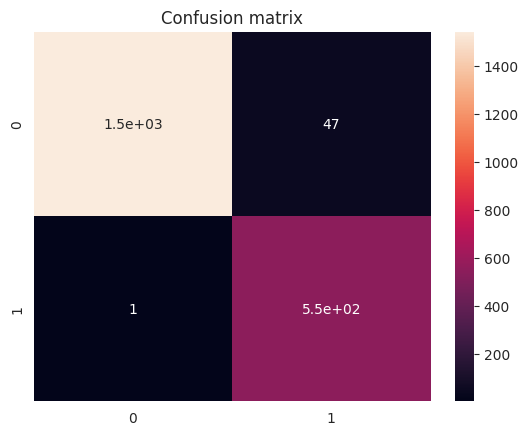

In [33]:
# Model Evaluation | Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(dpi=100)
sns.heatmap(cm, annot=True)
plt.title("Confusion matrix")
plt.show()